# Variational Auto-Encoder (VAE)

---

## **Latent Variable Models**

Given a dataset:

$$
D = \{ x_i \}_{i=1}^N, \quad x_i \in \mathbb{R}^d
$$

A **latent variable model** introduces a hidden variable \( z \) such that:

$$
p_\theta(x) = \int p_\theta(x, z) \, dz
= \int p_\theta(x|z)\, p(z)\, dz
$$

---

### **Problem**

- Maximum Likelihood Estimation:

$$
\theta^* = \arg \max_\theta \sum_{i=1}^N \log p_\theta(x_i)
$$

- Intractable because the **posterior** \( p_\theta(z|x) \) is **unknown**.

---

## **Variational Inference**

We introduce an **approximate posterior** \( q_\phi(z|x) \) and optimize the **Evidence Lower Bound (ELBO):**

$$
\log p_\theta(x)
\geq
\mathbb{E}_{q_\phi(z|x)} \big[ \log p_\theta(x|z) \big]
-
KL \big( q_\phi(z|x) \| p(z) \big)
$$

- **Reconstruction term:**  
$$
\mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)]
$$

- **Regularization term:**  
$$
KL(q_\phi(z|x)\|p(z))
$$

---

## **VAE Neural Networks**

- **Encoder (Inference Network):**  

$$
q_\phi(z|x) \approx \mathcal{N}(\mu_\phi(x), \sigma_\phi^2(x) I)
$$

- **Decoder (Generative Network):**  

$$
p_\theta(x|z) \approx \mathcal{N}(\mu_\theta(z), \sigma_\theta^2(z) I)
$$

---

### **VAE Training Objective (ELBO)**

$$
\mathcal{L}(\theta, \phi; x) =
\underbrace{\mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)]}_{\text{Reconstruction}}
-
\underbrace{KL(q_\phi(z|x)\|p(z))}_{\text{Regularization}}
$$

---

### **Training Algorithm**

1. Sample latent variable \( z \) using **reparameterization trick**:

$$
z = \mu_\phi(x) + \sigma_\phi(x) \odot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)
$$

2. Compute reconstruction \( x' \sim p_\theta(x|z) \)

3. Compute **ELBO** and update \((\theta, \phi)\) using gradient descent.

---

### **Benefits**

- Enables **posterior inference** $ q_\phi(z|x) $  
- Allows **generation of new samples** from $ p_\theta(x) $  
- Useful in **images, text, and audio generation**


## 1 – Install Dependencies and Import Libraries

In [1]:
# Install libraries if not in Colab
# !pip install jax jaxlib flax optax matplotlib tensorflow-datasets --quiet

import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from flax import linen as nn
from functools import partial
import numpy as np


## 2 – Load and Preprocess MNIST

In [2]:
def preprocess(example):
    image = example['image']
    image = jnp.array(image, dtype=jnp.float32) / 255.0  # normalize 0-1
    image = image.reshape(-1)  # flatten 28x28 -> 784
    return image

# Load dataset
ds = tfds.load('mnist', split='train', shuffle_files=True)
train_data = jnp.array([preprocess(x) for x in tfds.as_numpy(ds.take(10000))])  # smaller subset for speed

print("Training data shape:", train_data.shape)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.SWJGIN_3.0.1/mnist-train.tfrecord*...:   0%|          | 0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.SWJGIN_3.0.1/mnist-test.tfrecord*...:   0%|          | 0/…

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
Training data shape: (10000, 784)


## 3 – Define VAE Model

In [3]:
latent_dim = 2  # 2D latent space for visualization
input_dim = 28*28

class Encoder(nn.Module):
    hidden_dim: int = 256
    latent_dim: int = 2

    @nn.compact
    def __call__(self, x):
        x = nn.relu(nn.Dense(self.hidden_dim)(x))
        mu = nn.Dense(self.latent_dim)(x)
        log_var = nn.Dense(self.latent_dim)(x)
        return mu, log_var

class Decoder(nn.Module):
    hidden_dim: int = 256
    output_dim: int = 28*28

    @nn.compact
    def __call__(self, z):
        z = nn.relu(nn.Dense(self.hidden_dim)(z))
        logits = nn.Dense(self.output_dim)(z)
        return nn.sigmoid(logits)  # output in [0,1]

encoder = Encoder()
decoder = Decoder()


## 4 – Define Sampling and ELBO Loss

In [4]:
def sample_latent(mu, log_var, key):
    eps = jax.random.normal(key, mu.shape)
    return mu + jnp.exp(0.5 * log_var) * eps

def elbo_loss(params, key, batch):
    # Forward pass
    mu, log_var = encoder.apply({'params': params['enc']}, batch)
    key, subkey = jax.random.split(key)
    z = sample_latent(mu, log_var, subkey)
    recon = decoder.apply({'params': params['dec']}, z)

    # Reconstruction loss (binary cross-entropy)
    bce = -jnp.sum(batch * jnp.log(recon + 1e-7) + (1-batch)*jnp.log(1-recon+1e-7), axis=1)

    # KL divergence
    kl = -0.5 * jnp.sum(1 + log_var - mu**2 - jnp.exp(log_var), axis=1)

    return jnp.mean(bce + kl), (jnp.mean(bce), jnp.mean(kl))


## 5 – Initialize Parameters and Optimizer



In [5]:
# Initialize parameters
key = jax.random.PRNGKey(0)
x_init = train_data[:1]  # one example for init

enc_params = encoder.init(key, x_init)['params']
key, subkey = jax.random.split(key)
z_init = jax.random.normal(subkey, (1, latent_dim))
dec_params = decoder.init(key, z_init)['params']

params = {'enc': enc_params, 'dec': dec_params}

# Optimizer
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)


## 6 – Training Loop with Step Printing

In [6]:
@jax.jit
def train_step(params, opt_state, key, batch):
    (loss, (bce, kl)), grads = jax.value_and_grad(elbo_loss, has_aux=True)(params, key, batch)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss, bce, kl

batch_size = 128
epochs = 10

for epoch in range(1, epochs+1):
    # Shuffle
    perm = np.random.permutation(train_data.shape[0])
    train_data_perm = train_data[perm]

    total_loss = 0
    for i in range(0, len(train_data_perm), batch_size):
        batch = train_data_perm[i:i+batch_size]
        key, subkey = jax.random.split(key)
        params, opt_state, loss, bce, kl = train_step(params, opt_state, subkey, batch)
        total_loss += loss

    print(f"Epoch {epoch} | Loss: {total_loss/len(train_data_perm):.4f} | Recon: {bce:.4f} | KL: {kl:.4f}")


Epoch 1 | Loss: 2.0008 | Recon: 202.7703 | KL: 6.2967
Epoch 2 | Loss: 1.5484 | Recon: 196.8372 | KL: 6.1564
Epoch 3 | Loss: 1.5019 | Recon: 175.8527 | KL: 6.9584
Epoch 4 | Loss: 1.4724 | Recon: 149.6907 | KL: 6.4039
Epoch 5 | Loss: 1.4552 | Recon: 183.8827 | KL: 4.5938
Epoch 6 | Loss: 1.4357 | Recon: 194.5426 | KL: 5.7706
Epoch 7 | Loss: 1.4153 | Recon: 173.6707 | KL: 5.4117
Epoch 8 | Loss: 1.3990 | Recon: 201.1222 | KL: 4.8303
Epoch 9 | Loss: 1.3851 | Recon: 182.4953 | KL: 4.5794
Epoch 10 | Loss: 1.3720 | Recon: 152.7181 | KL: 5.5787


## 7 – Visualize Latent Space

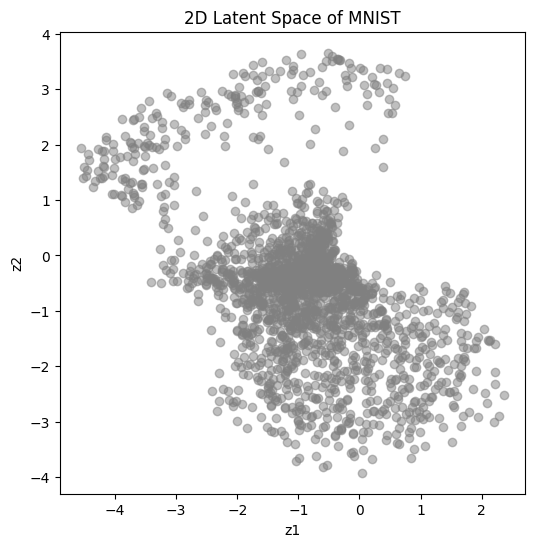

In [7]:
mu, log_var = encoder.apply({'params': params['enc']}, train_data[:2000])
z = mu  # mean as latent representation

plt.figure(figsize=(6,6))
plt.scatter(z[:,0], z[:,1], c='gray', alpha=0.5)
plt.title("2D Latent Space of MNIST")
plt.xlabel("z1")
plt.ylabel("z2")
plt.show()


## 8 – Generate New Samples from Latent Space

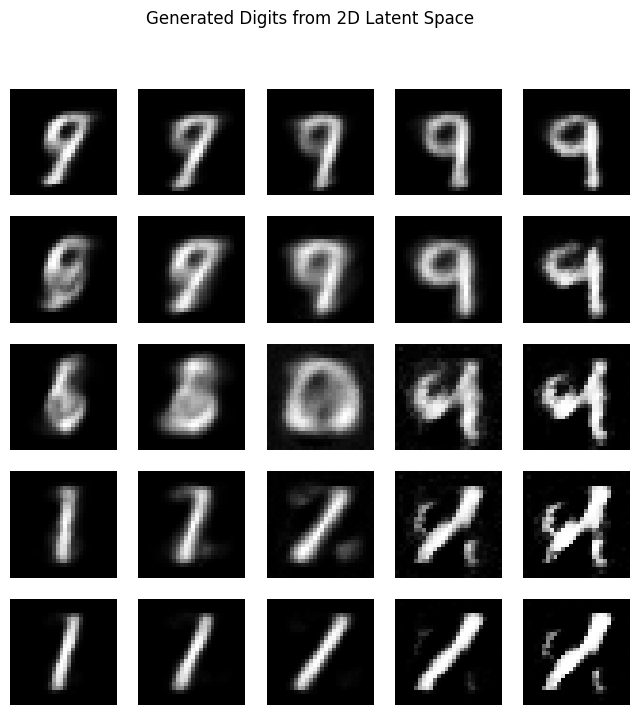

In [8]:
# Sample a grid in latent space
n = 5
grid_x = jnp.linspace(-3, 3, n)
grid_y = jnp.linspace(-3, 3, n)

fig, axes = plt.subplots(n, n, figsize=(8,8))
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = jnp.array([[xi, yi]])
        x_gen = decoder.apply({'params': params['dec']}, z_sample)
        axes[i,j].imshow(x_gen.reshape(28,28), cmap='gray')
        axes[i,j].axis('off')
plt.suptitle("Generated Digits from 2D Latent Space")
plt.show()
